<a href="https://colab.research.google.com/github/hartwj/Political_Liars/blob/main/Political_Liars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Political Liars


## Background

The Washington Post [estimates](https://www.washingtonpost.com/politics/2020/07/13/president-trump-has-made-more-than-20000-false-or-misleading-claims/) that President Donald Trump has made misleading statements over 20,000 times during his time in office. Fake news has permeated politics and even [influenced](https://www.latimes.com/science/sciencenow/la-sci-sn-fake-news-election-20190319-story.html) the 2016 election.

[Politifact](https://www.politifact.com/) has gathered over 12,000 political tweets and annotated them for truth-value. As we approach the 2020 election, fact-checking is paramount to ensuring the integrity of the election cycle. 

The ultimate goal of this project is to build a model with machine learning, trained on a subset of this data that could be used to predict the accuracy of future tweets at scale. 

# Primary Task

The majority of the work will be spent on the "Train.json" file which contains 10,239 tweets. My plan is to run several different text-processing models and apply the most successful (evaluated by mainly by accuracy and kappa) model on the "Test.json" file. 


I'll start the primary task by comparing Naïve Bayes, Logistic Regression, and SVMs models on a unigram feature space. Then I'll compare a unigram feature space with a feature space that also includes longer N-grams. Next I'll vary the vocabulary size of the n-gram feature space and evaluate how performance changes. After that I'll select the best model and tune the hyperparameters. Finally I'll take that model and use it on the held-out test set. 

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y61x56WR4jcVOE6dTkPzu0djIfubfQCa' -O Twitter_Data.json

--2021-03-01 01:32:48--  https://docs.google.com/uc?export=download&id=1y61x56WR4jcVOE6dTkPzu0djIfubfQCa
Resolving docs.google.com (docs.google.com)... 108.177.97.100, 108.177.97.102, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v1cueerg0r7ate8nq83mjcfnt9hs7bfv/1614562350000/14947468445787936960/*/1y61x56WR4jcVOE6dTkPzu0djIfubfQCa?e=download [following]
--2021-03-01 01:32:49--  https://doc-08-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v1cueerg0r7ate8nq83mjcfnt9hs7bfv/1614562350000/14947468445787936960/*/1y61x56WR4jcVOE6dTkPzu0djIfubfQCa?e=download
Resolving doc-08-7k-docs.googleusercontent.com (doc-08-7k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-08-7k-docs.googleusercontent.com (doc-08-7k-d

**Import Libraries and Useful Definitions**

In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines
#@ignore_warnings(category=ConvergenceWarning)
#@ignore_warnings(category=UndefinedMetricWarning)
# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=123)


    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison

In [ ]:
data = pd.read_csv('Twitter_Data.json', sep='\t')
print(data.shape)
data.head()

(10239, 14)


,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [ ]:
#rename columns re: codebook
data.columns = ['ID','Label','Statement',
                     'Subject','Speaker','Job_title','State','Party',
               'Barely_true','False','Half_true','Mostly_true','Pants_on_fire',"Context" ]

In [ ]:
data.head()

,ID,Label,Statement,Subject,Speaker,Job_title,State,Party,Barely_true,False,Half_true,Mostly_true,Pants_on_fire,Context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [ ]:
#Calculate the % truth of a statement by creating new columns
data["True_count"] = data["Barely_true"] + data["Half_true"] + data["Mostly_true"]
data["False_count"] = data["False"] + data["Pants_on_fire"]
data["Total"] = data["True_count"] + data["False_count"]
data["True_%"] = data["True_count"] / data["Total"]
data["False_%"] = data["False_count"] / data["Total"]
data.head(3)

,ID,Label,Statement,Subject,Speaker,Job_title,State,Party,Barely_true,False,Half_true,Mostly_true,Pants_on_fire,Context,True_count,False_count,Total,True_%,False_%
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2.0,0.0,2.0,1.000000,0.000000
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,393.0,80.0,473.0,0.830867,0.169133
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,15.0,63.0,78.0,0.192308,0.807692


In [ ]:
#creating a binary label for each tweet as either true or false
#half-true was rounded up to true
def Binary_label(x):
    if x == "barely-true":
        return "true"
    if x == "half-true":
        return "true"
    if x == "true":
        return "true"
    if x == "mostly-true":
        return "true"
    if x == "false":
        return "false"
    if x == "pants-fire":
        return "false"
    else:
        return "n/a"

data["Binary_label"] = data["Label"].apply(Binary_label)
data["Binary_label"].value_counts()
data.head(1)

,ID,Label,Statement,Subject,Speaker,Job_title,State,Party,Barely_true,False,Half_true,Mostly_true,Pants_on_fire,Context,True_count,False_count,Total,True_%,False_%,Binary_label
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,2.0,0.0,2.0,1.0,0.0,true


In [ ]:
#how are the statements distributed by accuracy
data["Label"].value_counts()

half-true      2114
false          1994
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: Label, dtype: int64

# Task 1: Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space 

**Pre-Processing**

In [ ]:
#coverting tweets into bag of words model
#for the first task I'm keep vocab at 1000 since greater values weigh on processing speed
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")

when: 964
did: 286
the: 868
of: 619
coal: 220
start: 827
it: 479
started: 828
gas: 382
took: 896
off: 620
that: 866
to: 891
in: 456
president: 685
george: 387
administration: 63
hillary: 435
clinton: 216
with: 975


In [ ]:
#creating a new dataframe
#vocab words will now be columns in the new df
#I wanted to run a binary model and multi-class model to see which was more accurate
bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

bow_df["Binary_A"] = data["Binary_label"].values
bow_df["Multi_B"] = data["Label"].values  

bow_df

,000,10,100,11,12,13,14,15,150,16,17,18,19,20,200,2000,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,21,22,23,24,25,250,28,30,300,35,40,400,45,50,...,weve,what,when,where,whether,which,while,white,who,why,will,wisconsin,wisconsins,with,within,without,woman,women,won,work,worked,worker,workers,working,world,worst,worth,would,wrote,year,years,yet,york,you,young,your,youre,zero,Binary_A,Multi_B
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,half-true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,mostly-true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,half-true
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,true,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,mostly-true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,mostly-true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true,half-true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false,false


**Running the Models**

In [ ]:
#Use the Unigram BOW dataframe to test the following models:
#Bernoulli NB, Logistic Regression, and Support Vector Machine (SVM)
#Optimize for Kappa
#I ran this a 2nd time with the multi-class labels (but excluded since processing time is slow)

classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression" : LogisticRegression(max_iter = 4000),
    "Support Vector Machine": LinearSVC(max_iter = 10000,dual = True)}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Kappa'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["true","false"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "Binary_A", labels=sorted_sentiments, noisy = 'quiet')

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.159
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.080
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.085
-------------


In [ ]:
metric_to_optimize = 'Accuracy'
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "Binary_A", labels=sorted_sentiments, noisy = 'quiet')

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 68.083
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 69.557
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 69.401
-------------


**Results**

I created a bag of words dataframe with only unigrams, capping the vocabulary size at 1000 words. Next I ran three different models - Naive Bayes, Logistic Regression, and Support Vector Machines - optimizing for accuracy and kappa scores. I used 10 k-folds and recorded average performance across the folds below. 

The first series of prediction models are based on a binary classification for each tweet as either true/false. The second table shows a multi-class predicition ranging from a tweet being labeled as "true" to "pants on fire". 

Overall the binary prediction models performed substantially better from an accuracy standpoint, although the kappa values were closer than I expected. For binary predictions, the Logistic Regression models had the highest average accuracy at approximately 70%, but Naive Bayes had the highest average kappa at 0.16. 

Going forward in this experiment, I will focus solely on binary prediction labels.



> Binary Prediction:


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|68.1%|0.16
|Logistic Regression|70%|0.08
|Support Vector Machine|69%|0.09

> Multi-Class Prediction:


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|24.8%|0.09
|Logistic Regression|23.5%|0.07
|Support Vector Machine|23.1%|0.06


# Task 2: Comparing Unigram Models with Bigram and Trigram Feature Spaces

**Pre-processing**

Ok I'm going to build three new feature spaces - 
Bigram, Trigram, and Bi+Trigram

In [ ]:
#Bi-Gram Dataframe
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,2)) #the magic cell
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_bi = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_bi.columns = column_names

bow_df_bi["Prediction"] = data["Binary_label"].values

bow_df_bi

natural gas: 441
president george: 561
hillary clinton: 280
john mccain: 388
to give: 867
george bush: 228
of the: 492
health care: 275
care reform: 139
likely to: 401
the economic: 745
at the: 97
the end: 747
end of: 182
have had: 261
in the: 344
the last: 764
10 years: 9
than the: 701
the total: 812


,000 in,000 jobs,000 new,000 people,000 per,000 to,000 year,10 000,10 percent,10 years,100 000,100 million,100 percent,15 percent,20 000,20 percent,20 years,200 000,25 percent,250 000,30 000,30 percent,30 years,300 000,40 percent,400 000,50 000,50 percent,500 billion,60 percent,70 percent,75 percent,80 percent,90 percent,95 percent,able to,about the,access to,according to,across the,...,white house,who are,who has,who have,who is,who voted,who were,will be,will cost,will have,will not,wisconsin gov,wisconsin is,with an,with no,with the,won the,world war,would be,would cost,would cut,would have,would not,year and,year in,year to,years ago,years and,years in,years of,years old,you are,you can,you cant,you dont,you have,you know,you look,young people,Prediction
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


In [ ]:
#Trigram Dataframe
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(3,3)) #trigrams
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_tri = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_tri.columns = column_names

bow_df_tri["Prediction"] = data["Binary_label"].values

bow_df_tri

president george bushs: 571
health care reform: 248
the end of: 756
in the last: 309
the last 10: 784
last 10 years: 358
during the last: 147
the last two: 792
some of the: 667
for the first: 171
the first time: 770
first time in: 157
time in history: 878
out of the: 528
the middle class: 798
when mitt romney: 981
mitt romney was: 393
romney was governor: 602
was governor of: 960
governor of massachusetts: 201


,000 jobs and,000 jobs in,000 new jobs,000 new private,000 per year,10 percent of,100 percent of,15 percent of,20 percent of,25 percent of,30 percent of,40 percent of,50 percent of,500 billion in,60 percent of,70 percent of,75 percent of,77 cents for,80 percent of,85 percent of,90 percent of,95 percent of,97 percent of,98 percent of,99 percent of,about 40 percent,about half of,about percent of,about the same,according to the,across the country,affordable care act,all of the,all the other,all time high,am the only,amount of money,an all time,an average of,and barack obama,...,was in the,was mayor of,was one of,was running for,was the first,was the only,we are the,we dont have,we had the,we have been,we have more,we have the,we have to,we know that,we now have,were going to,were killed by,were the only,when he was,when it comes,when mitt romney,when took office,whether or not,will be the,will have to,wisconsin gov scott,wisconsin supreme court,with nancy pelosi,without raising taxes,world war ii,worst in the,would be the,would have to,years ago the,years in row,you have to,you know that,you look at,your tax dollars,Prediction
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


In [ ]:
vocab_size = 1000

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,3)) #bis and tris
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_df_bitri = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_bitri.columns = column_names

bow_df_bitri["Prediction"] = data["Binary_label"].values

#look at it#
bow_df_bitri

president george: 555
hillary clinton: 265
john mccain: 376
to give: 878
george bush: 211
of the: 478
health care: 256
care reform: 139
likely to: 388
health care reform: 260
the economic: 739
at the: 98
the end: 741
end of: 176
the end of: 742
have had: 244
in the: 323
the last: 764
10 years: 10
than the: 692


,000 in,000 jobs,000 new,000 people,000 per,000 to,000 year,10 000,10 percent,10 percent of,10 years,100 000,100 percent,15 percent,20 000,20 percent,20 years,200 000,25 percent,25 percent of,250 000,30 000,30 percent,30 years,300 000,40 percent,40 percent of,50 000,50 percent,50 percent of,500 billion,60 percent,60 percent of,70 percent,70 percent of,80 percent,80 percent of,90 percent,90 percent of,95 percent,...,when they,when was,when we,when you,which is,while the,white house,who are,who have,who is,who voted,who were,will be,will cost,will have,will not,wisconsin gov,wisconsin gov scott,wisconsin is,with no,with the,world war,world war ii,would be,would have,would not,year and,year in,year to,years ago,years and,years in,years of,you are,you can,you cant,you dont,you have,you know,Prediction
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


**Running the Models**

In [ ]:
#I toggled the names of the n gram dataframes on the last line to get results
#had to move this block of code below each df to run

classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression": LogisticRegression(max_iter = 4000),
    "Support Vector Machine": LinearSVC(max_iter = 10000,dual = True)}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Accuracy' #toggled with kappa
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["true","false"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df_bitri, feature_set,"Prediction", labels=sorted_sentiments, noisy = 'quiet')


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 69.226
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 70.866
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 69.929
-------------


**Results**

After creating the three new dataframes (bigrams, trigrams, and bi+trigrams) I evaluated performance in comparison to the unigram dataframe from the first task. 

Overall the models from the trigrams performed best from an accuracy standpoint - ranging from 70.3% to 71.8%. The most accurate model was the logistic regression applied to the trigram dataframe at 71.8% accuracy. 

The highest kappa values came from the unigram models completed in task 1, ranging from 0.08 for Logistic Regression to 0.16 for Naive Bayes. 

> Unigram Prediction (Task 1):


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|68.1%|0.16
|Logistic Regression|70%|0.08
|Support Vector Machine|69%|0.09

> Bigram Prediction:


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|69.7%|0.09
|Logistic Regression|70.2%|0.05
|Support Vector Machine|69.3%|0.05

> Trigram Prediction:


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|71%|0.08
|Logistic Regression|71.8%|0.04
|Support Vector Machine|70.3%|0.05

> Bigram and Trigrams:


|Model| Accuracy | Kappa
|-----|----------|------
|Naïve Bayes|69.2%|0.09
|Logistic Regression|70.9%|0.06
|Support Vector Machine|69.9%|0.05

# Task 3: Adjusting the vocabulary size

In the previous tasks, the vocabulary size has been set at the most common 1000 words. I'm going to look at our most successful BOW dataframe from task 2 - unigrams - and evaluate model results at varying vocabulary sizes. 

**Pre-processing**

In [ ]:
#I'm going to use vocab sizes from 250-1250 with 250 word steps
#The next sections of code were toggled to get results
vocab_size = 1250

vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")

when: 1210
did: 353
the: 1100
of: 780
coal: 272
start: 1049
it: 608
started: 1050
natural: 753
gas: 482
took: 1132
off: 781
that: 1098
to: 1126
in: 574
president: 860
george: 488
administration: 79
hillary: 547
clinton: 267


In [ ]:
#Building the DF
bow_df_size = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df_size.columns = column_names

bow_df_size["Label_A"] = data["Binary_label"].values

bow_df_size

,000,10,100,11,12,13,14,15,150,16,17,18,19,20,200,2000,2001,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,21,22,23,24,25,250,27,28,29,30,300,33,...,where,whether,which,while,white,who,why,will,wind,wisconsin,wisconsins,with,within,without,woman,women,won,wont,work,worked,worker,workers,workforce,working,world,worse,worst,worth,would,wrote,year,years,yet,york,you,young,your,youre,zero,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


**Running the Models**

In [ ]:
#Evaluating the 3 models
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression" : LogisticRegression(max_iter=4000),
    "Support Vector Machine": LinearSVC(max_iter = 10000,dual = True)}

metrics = {
    "Accuracy" : lambda y, y_pred: 100*(accuracy_score(y,y_pred)),
    "Kappa"    : cohen_kappa_score
}

metric_to_optimize = 'Kappa'
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["true", "false"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df_size, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet')


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.160
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.085
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.087
-------------


**Results**

The models seemed to be less accurate at higher vocabulary sizes. The most accurate model was a tie between Logistic Regression and SVMs at 72% with 250 words. The Naive Bayes model had the highest kappa values at varying word sizes. 


> Vocab Size = 250:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 70.6%| .15
|Logistic Regression| 72%| .06
|Support Vector Machine|72%| .05


> Vocab Size = 500:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 69%| .16
|Logistic Regression| 70.8%| .07
|Support Vector Machine|71.1%| .06

> Vocab Size = 750:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 68.4%| .15
|Logistic Regression| 70.2%| .08
|Support Vector Machine|70.1%| .07

> Vocab Size = 1000:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 68.1%| .16
|Logistic Regression| 69.6%| .08
|Support Vector Machine|69.4%| .09

> Vocab Size = 1250:

| Model | Accuracy | Kappa
|-------|----------|------
|Naive Bayes| 68%| .16
|Logistic Regression| 69.2%| .09
|Support Vector Machine|68.5%| .09

# Task 4: Hyperparameter Tuning

The next phase of this assignment will be hyperparamter tuning some of our best models from the first three tasks. I want to compare different Naive Bayes models, since they've been producing our highest kappa values. We've been analyzin only Bernoulli, so I want to look at Complement NB and Multinomial NB. 

I have settled on a vocabulary size of 250 most common words/phrases. My n-grams will be from the most common unigrams. While trigrams had the most overall accuracy, unigrams had the highest kappa values. I also included stopwords. 

**Building the Feature Space**

In [ ]:
#new data frame

vocab_size = 250

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,1),lowercase=False)
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_hyper = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_hyper.columns = column_names

bow_hyper["Label_A"] = data["Binary_label"].values

bow_hyper

When: 57
did: 95
the: 210
of: 165
It: 26
when: 235
took: 222
off: 166
that: 209
to: 220
in: 133
President: 37
administration: 61
Hillary: 22
Clinton: 14
with: 240
John: 27
McCain: 28
by: 80
Bush: 13


,000,10,100,20,30,40,50,Act,America,American,Americans,Barack,Bill,Bush,Clinton,Congress,County,Democrats,Donald,Florida,Georgia,Gov,Hillary,House,If,In,It,John,McCain,Medicare,Mitt,New,Obama,Obamacare,Obamas,Ohio,On,President,Republican,Republicans,...,their,them,there,they,this,those,three,time,times,to,today,took,trillion,two,under,unemployment,up,vote,voted,wants,was,we,were,what,when,which,while,who,will,with,without,women,work,world,would,year,years,you,your,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


**Running the Naive Bayes Models**

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["true", "false"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_hyper, feature_set, "Label_A", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.162
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.164
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.130
-------------
Best classifier is: Complement NB 
With K=0.164.


To save the details, I experimented with different vocab sizes, different n-grams, stopwords, and case-sensitive parameters. This brief analysis showed that Benoulli NB performed the best. While Complement NB did have the highest kappa value, Bernoulli was more consistent and had much better accuracy. 

Based on the parameters above, Bernoulli NB has an average accuracy of 71.26% and an average kappa of 0.162. 

# Testing the Best Model

The final step will be uploading the test dataset and using our best model, trained on training data, and see how it performs on the test dataset. The new dataset will only be about 1000 tweets. 

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PSmmitYzkmWtdFsw75qSvz9xhy6RPLXr' -O Twitter_Test.json

--2021-03-01 01:36:38--  https://docs.google.com/uc?export=download&id=1PSmmitYzkmWtdFsw75qSvz9xhy6RPLXr
Resolving docs.google.com (docs.google.com)... 74.125.203.113, 74.125.203.139, 74.125.203.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qh1mihhr504uqphsalbus215vkmuir1e/1614562575000/14947468445787936960/*/1PSmmitYzkmWtdFsw75qSvz9xhy6RPLXr?e=download [following]
--2021-03-01 01:36:39--  https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qh1mihhr504uqphsalbus215vkmuir1e/1614562575000/14947468445787936960/*/1PSmmitYzkmWtdFsw75qSvz9xhy6RPLXr?e=download
Resolving doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-10-7k-docs.googleusercontent.com (doc-10-7k-d

In [ ]:
#pre-processing copied from earlier
data_test = pd.read_csv('Twitter_Test.json', sep='\t')
print(data_test.shape)
data_test.columns = ['ID','Label','Statement',
                     'Subject','Speaker','Job_title','State','Party',
               'Barely_true','False','Half_true','Mostly_true','Pants_on_fire',"Context" ]

data_test["Binary_label"] = data_test["Label"].apply(Binary_label)
print(data_test["Binary_label"].value_counts())
data_test.head()

(1266, 14)
true     925
false    341
Name: Binary_label, dtype: int64


,ID,Label,Statement,Subject,Speaker,Job_title,State,Party,Barely_true,False,Half_true,Mostly_true,Pants_on_fire,Context,Binary_label
0,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,false
1,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,false
2,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,true
3,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,false
4,5962.json,true,Over the past five years the federal governmen...,"federal-budget,pensions,retirement",brendan-doherty,NaN,Rhode Island,republican,1,2,1,1,0,a campaign website,true


**Building the Train and Test Feature Spaces**

In [ ]:
#best model from hyperparameter tuning
#creating a final feature space from the training data

vocab_size = 250

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,1), lowercase=False)
X = vectorizer.fit_transform(data["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_train_final_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_train_final_df.columns = column_names

bow_train_final_df["Label_A"] = data["Binary_label"].values

bow_train_final_df

When: 57
did: 95
the: 210
of: 165
It: 26
when: 235
took: 222
off: 166
that: 209
to: 220
in: 133
President: 37
administration: 61
Hillary: 22
Clinton: 14
with: 240
John: 27
McCain: 28
by: 80
Bush: 13


,000,10,100,20,30,40,50,Act,America,American,Americans,Barack,Bill,Bush,Clinton,Congress,County,Democrats,Donald,Florida,Georgia,Gov,Hillary,House,If,In,It,John,McCain,Medicare,Mitt,New,Obama,Obamacare,Obamas,Ohio,On,President,Republican,Republicans,...,their,them,there,they,this,those,three,time,times,to,today,took,trillion,two,under,unemployment,up,vote,voted,wants,was,we,were,what,when,which,while,who,will,with,without,women,work,world,would,year,years,you,your,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


In [ ]:
#test data

vocab_size = 250

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(1,1), lowercase=False)
X = vectorizer.fit_transform(data_test["Statement"])

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_Tfinal_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_Tfinal_df.columns = column_names

bow_Tfinal_df["Label_A"] = data_test["Binary_label"].values

bow_Tfinal_df.head(5)

Wisconsin: 54
is: 135
on: 165
to: 216
the: 207
of: 163
this: 212
year: 246
Says: 41
John: 24
McCain: 25
has: 118
plan: 179
that: 206
will: 240
cut: 89
for: 106
Medicare: 26
When: 53
by: 77


,000,10,15,20,30,50,500,America,American,Americans,Barack,Clinton,Congress,County,Democrats,Donald,Florida,Georgia,Gov,Hillary,House,If,In,Iraq,John,McCain,Medicare,Milwaukee,Mitt,New,Obama,Obamacare,Obamas,Ohio,On,President,Rep,Republican,Republicans,Rick,...,they,this,three,time,times,to,today,took,trillion,true,two,under,unemployment,up,use,vote,voted,wage,want,wants,war,was,we,went,were,when,which,while,who,will,with,without,women,work,would,year,years,you,your,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,false
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,true
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,true


**Running the Models with SKLearn**

Kappa Score is 0.044504
Accuracy is 0.717220
Precision Score is 0.717219589257504


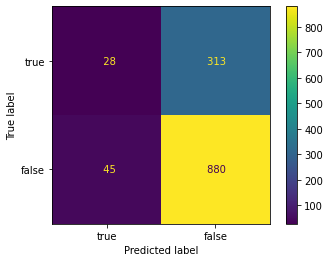

In [ ]:
#Introducing the k folds and SKlearn

X_trainFINAL= bow_train_final_df.iloc[:,:-1]
X_trainFINAL=pd.get_dummies(X_trainFINAL)
y_trainFINAL=bow_train_final_df["Label_A"]


Model = BernoulliNB().fit(X_trainFINAL,y_trainFINAL)

X_testFINAL=bow_Tfinal_df.iloc[:,:-1]
X_testFINAL=pd.get_dummies(X_testFINAL)

y_testFINAL=bow_Tfinal_df["Label_A"]

y_predFINAL = Model.predict(X_testFINAL)




Accuracy = accuracy_score(y_testFINAL,y_predFINAL)
Kappa = cohen_kappa_score(y_testFINAL,y_predFINAL)
Precision = precision_score(y_testFINAL,y_predFINAL, average='micro')
cmatrix = confusion_matrix(y_testFINAL,y_predFINAL)
print(f"Kappa Score is {Kappa:2f}")
print(f"Accuracy is {Accuracy:2f}")
print(f"Precision Score is {Precision:}")
ConfusionMatrixDisplay(cmatrix,["true", "false"]).plot(values_format = '4g')
plt.show()

## Results - Test Dataset

Based on the training data, I went with a unigram dataframe with a 250 vocabulary count. I then used sklearn to run all three naive bayes models, as well as logistic regression and linear SVC models. 

The Bernoulli NB actually reported higher accuracy on the test data, 72.7% vs. 71.26%, but the kappa fell dramatically from .16 to .04. All of the kappa values were extremely low on the test dataset.


|Model|Accuracy|Kappa
|-----|--------|-----
|Bernoulli NB| 72.7%| .04
|Complement NB| 63.3%| .006
|Multinonmial NB|71.8%|.009
|Logistic Regression|72.7%|.02
|Linear SVC|72.2%|0

While I'm not thrilled with the results, I am encouraged by the accuracy percentages in identifying true and false tweets. To take this further I would've included POS tagging and stemming.

# Extension Task

For my extension task, I've decided to split it up into two parts. The first part will be evaluating the dataset based on a new feature - speaker. While BOW is helpful with identifying tweets, I have a feeling that certain speakers are more likely to be truthful than others. I will build a new model trained on the bigrams of speakers and then evaluate it on the test dataset. 


**Training the Models**

In [ ]:
#new data frame

vocab_size = 600

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,2)) #bigrams only
X = vectorizer.fit_transform(data["Speaker"].fillna(' '))

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_speaker = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_speaker.columns = column_names

bow_speaker["Label_B"] = data["Binary_label"]

bow_speaker

barack obama: 35
blog posting: 54
charlie crist: 77
robin vos: 490
republican party: 470
party texas: 421
robert menendez: 489
mitt romney: 395
george will: 212
national republican: 402
republican congressional: 467
congressional committee: 104
gwen moore: 232
dennis richardson: 144
hillary clinton: 239
greater wisconsin: 226
wisconsin political: 597
political fund: 445
planned parenthood: 442
action fund: 2


,21st century,action committee,action fund,adam hasner,adam putnam,afl cio,al gore,alan grayson,alberta darling,alcee hastings,alex sink,alison lundergan,allan fung,allen west,america now,american bridge,american crossroads,american future,americans prosperity,americans tax,americans united,and commerce,and stronger,andrew cuomo,andrew napolitano,angel taveras,ann coulter,ann mclane,anthony gemma,arianna huffington,armond budish,arne duncan,austan goolsbee,back basics,bailey hutchison,barack obama,barbara boxer,barbara buono,barry hinckley,bee editorial,...,tennessee democratic,terry mcauliffe,texas right,tim canova,tim kaine,tim pawlenty,tim ryan,todd staples,tom barrett,tom coburn,tom cotton,tom graves,tom kean,tom price,tom tancredo,tommy thompson,united change,us chamber,usa action,van de,van jones,vanden heuvel,vern buchanan,vincent buddy,vincent fort,viral image,vote no,ward armstrong,wasserman schultz,wayne lapierre,we are,wendy davis,will weatherford,winning our,wisconsin manufacturers,wisconsin now,wisconsin political,women voters,workers voice,Label_B
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB(),
    "Logistic Regression" : LogisticRegression(max_iter = 4000),
    "Support Vector Machine": LinearSVC(max_iter = 10000,dual = True)
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
bow_features = column_names
feature_set = bow_features
sorted_sentiments = ["true", "false"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_speaker, feature_set, "Label_B", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 72.908
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 51.567
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 73.064
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 73.747
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 73.142
-------------
Best classifier is: Logistic Regression 
With K=73.747.


## Results - Train Data


Best results seemed to be about a vocabulary size of 600. I was hoping for better results, but I think overall this was an improvement from analyzing tweet text using BOW. A couple models had kappas in the .15 - .16 range which was comparable to the tweet predictions. 

|Model|Accuracy|Kappa
|-----|--------|-----
|Bernoulli NB| 72.9%| .15
|Complement NB| 51.6%| .10
|Multinonmial NB|73.1%|.16
|Logistic Regression|73.7%|.14
|Linear SVC|73.1%|.16

**Testing the Models**

In [ ]:
#build training data final

vocab_size = 600

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,2))
X = vectorizer.fit_transform(data["Subject"].fillna(' '))

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_train_final_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_train_final_df.columns = column_names

bow_train_final_df["Label_A"] = data["Binary_label"].values

bow_train_final_df

history job: 347
job accomplishments: 401
foreign policy: 312
health care: 334
economy jobs: 211
candidates biography: 94
energy message: 272
message machine: 455
machine 2014: 441
voting record: 595
new hampshire: 465
hampshire 2012: 333
history state: 356
state budget: 565
economy federal: 198
federal budget: 298
budget health: 68
financial regulation: 308
bankruptcy economy: 31
economy income: 208


,2012 campaign,2012 military,2012 state,2012 stimulus,2012 taxes,2012 voting,2012 workers,abc news,abortion candidates,abortion children,abortion congress,abortion corrections,abortion crime,abortion government,abortion health,abortion message,abortion women,accomplishments campaign,accomplishments jobs,accomplishments legal,accomplishments message,accomplishments state,accomplishments taxes,afghanistan foreign,afghanistan military,agriculture animals,agriculture economy,and lesbians,and trade,and updates,bankruptcy candidates,bankruptcy economy,biography children,biography city,biography congress,biography corporations,biography corrections,biography crime,biography criminal,biography debates,...,small business,social security,sotomayor nomination,sports state,state budget,state finances,states taxes,states transportation,states women,states workers,stimulus taxes,stimulus transportation,stimulus voting,stimulus workers,supreme court,tampa bay,taxes abc,taxes transparency,taxes transportation,taxes voting,taxes wealth,taxes workers,technology transparency,terrorism transportation,trade climate,unions workers,updates crime,updates economy,updates education,updates elections,updates federal,updates foreign,updates guns,updates health,voting record,wall street,wealth workers,week workers,women workers,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
10237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false


In [ ]:
#test data

vocab_size = 600

vectorizer = CountVectorizer(max_features=vocab_size,ngram_range=(2,2))
X = vectorizer.fit_transform(data_test["Subject"].fillna(' '))

for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")


bow_Tfinal_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_Tfinal_df.columns = column_names

bow_Tfinal_df["Label_A"] = data_test["Binary_label"].values

bow_Tfinal_df.head(5)

military veterans: 425
veterans voting: 596
voting record: 597
medicare message: 412
message machine: 418
machine 2012: 387
2012 campaign: 0
campaign advertising: 100
campaign finance: 101
finance legal: 286
legal issues: 379
issues campaign: 329
federal budget: 281
budget pensions: 90
pensions retirement: 435
county budget: 150
budget county: 79
county government: 151
education taxes: 251
economy stimulus: 229


,2012 campaign,2012 military,2012 patriotism,2012 poverty,2012 retirement,2012 state,2012 stimulus,2012 taxes,2012 trade,2012 voting,2012 women,2014 campaign,2014 taxes,2014 women,abc news,abortion bipartisanship,abortion candidates,abortion corrections,abortion crime,abortion debates,abortion health,abortion legal,abortion pundits,accomplishments jobs,accomplishments labor,accomplishments message,accomplishments politifacts,accomplishments public,accomplishments state,accomplishments trade,accomplishments transportation,accomplishments voting,administration candidates,administration china,administration federal,administration pundits,advertising pop,advertising state,advertising trade,advertising voting,...,stimulus taxes,stimulus transportation,stimulus workers,supreme court,taxes abc,taxes technology,taxes trade,taxes transportation,taxes unions,taxes wealth,taxes welfare,taxes workers,technology trade,technology transportation,top promises,trade climate,trade voting,trade workers,transportation voting,unions workers,updates criminal,updates debates,updates economy,updates education,updates elections,updates energy,updates families,updates federal,updates food,updates guns,updates history,updates message,updates science,updates voting,updates water,veterans voting,voting record,wall street,women workers,Label_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,false
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,false
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,true


Kappa Score is -0.012970
Accuracy is 0.660348
Precision Score is 0.660347551342812


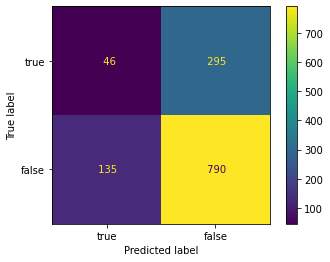

In [ ]:
#Introducing the k folds and SKlearn

X_trainFINAL= bow_train_final_df.iloc[:,:-1]
X_trainFINAL=pd.get_dummies(X_trainFINAL)
y_trainFINAL=bow_train_final_df["Label_A"]


Model = LinearSVC(max_iter = 10000,dual = True).fit(X_trainFINAL,y_trainFINAL)

X_testFINAL=bow_Tfinal_df.iloc[:,:-1]
X_testFINAL=pd.get_dummies(X_testFINAL)

y_testFINAL=bow_Tfinal_df["Label_A"]

y_predFINAL = Model.predict(X_testFINAL)




Accuracy = accuracy_score(y_testFINAL,y_predFINAL)
Kappa = cohen_kappa_score(y_testFINAL,y_predFINAL)
Precision = precision_score(y_testFINAL,y_predFINAL, average='micro')
cmatrix = confusion_matrix(y_testFINAL,y_predFINAL)
print(f"Kappa Score is {Kappa:2f}")
print(f"Accuracy is {Accuracy:2f}")
print(f"Precision Score is {Precision:}")
ConfusionMatrixDisplay(cmatrix,["true", "false"]).plot(values_format = '4g')
plt.show()

## Results - Test Data

Accuracy fell a couple per cent and kappa values plummeted when applying the models to the test dataset. The best performing on test data was Bernoulli NB with an accuracy of 69.8% and Kappa of .03. This was even worse than analyzing tweet data. Conclusively I can say that tweets are more predictive using BOW models in assigning truth/false than speakers. 



> Train Data

|Model|Accuracy|Kappa
|-----|--------|-----
|Bernoulli NB| 72.9%| .15
|Complement NB| 51.6%| .10
|Multinonmial NB|73.1%|.16
|Logistic Regression|73.7%|.14
|Linear SVC|73.1%|.16


> Test Data


|Model|Accuracy|Kappa
|-----|--------|-----
|Bernoulli NB| 69.8%| .03
|Complement NB| 46.5%| .006
|Multinonmial NB|70.1%|.02
|Logistic Regression|71.1%|.01
|Linear SVC|66%|0